In [1]:
import lazypredict
import pandas as pd
from sklearn.preprocessing import RobustScaler
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import lightgbm
from lightgbm import LGBMClassifier

In [4]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
df_X_last = pd.read_csv("data/X_train_features.csv", index_col=0)
df_X_richard = pd.read_csv("data/template_features_v3.csv", index_col=0)
df_X_tim = pd.read_csv("data/full_waveform_features.csv", index_col=0)
df_X_pyHRV = pd.read_csv("data/pyHRV_features.csv", index_col=0)
df_X_hrv_analysis = pd.read_csv("data/hrv-analysis_features.csv")
df_X = pd.concat((df_X_tim,df_X_richard),axis=1)
df_X = pd.concat((df_X, df_X_pyHRV),axis=1)
df_X = pd.concat((df_X, df_X_hrv_analysis),axis=1)
# df_X = pd.concat((df_X, df_X_last),axis=1)
df_Y = pd.read_csv("data/Y_train.csv", index_col="id")

Remove highly correlated features

In [5]:
def rm_corr(X):
    corr_matrix = X.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.9
    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
    print("Removed columns: ", len(to_drop))
    # Drop features 
    X.drop(to_drop, axis=1, inplace=True)
    #X_test.drop(to_drop, axis=1, inplace=True)
    
    return X

In [6]:
df_X.replace([np.inf, -np.inf], np.nan, inplace=True)
df_X = rm_corr(df_X)
feature_names = [col for col in df_X]

Removed columns:  45


In [7]:
transformer = RobustScaler()
X = transformer.fit_transform(df_X)

In [8]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X = imp_median.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, df_Y, stratify=df_Y, random_state=42)

In [10]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [11]:
importances = forest.feature_importances_
idx = np.argsort(-importances)
random_forest_names = [feature_names[i] for i in idx][:20]
importances = importances[idx][:20]

Text(0.5, 1.0, 'RandomForestFeatureImportance')

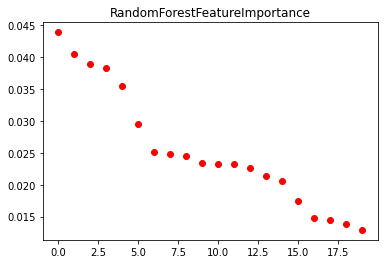

In [12]:
plt.plot(range(importances.shape[0]), importances, 'ro')
plt.title("RandomForestFeatureImportance")

In [13]:
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)

LGBMClassifier()

In [14]:
importances = lgbm_model.feature_importances_
idx = np.argsort(-importances)
lgbm_names = [feature_names[i] for i in idx][:20]
importances = importances[idx][:20]

Text(0.5, 1.0, 'LGBMFeatureImportance')

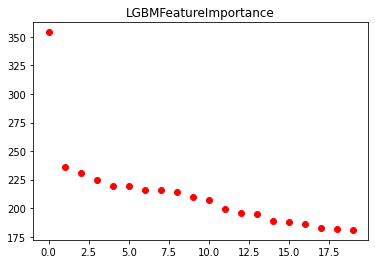

In [15]:
plt.plot(range(importances.shape[0]), importances, 'ro')
plt.title("LGBMFeatureImportance")

In [16]:
lgbm_names

['Pamp',
 'hr_std',
 'swt_d_4_energy_entropy',
 'pr',
 'af_evid',
 'qrs_corr_coeff_med',
 'P_amp_std',
 'swt_a_1_med_power_ratio',
 'nni_min',
 'duration',
 'min',
 'T_amp_std',
 'pr_std',
 'median',
 'swt_d_2_med_power_ratio',
 'Q_amp_std',
 'arhythm_index',
 'swt_a_2_low_power_ratio',
 'pnn20',
 'mean_nni']

In [17]:
random_forest_names

['nni_min',
 'arhythm_index',
 'hr_max',
 'pnn50',
 'nn50',
 'pnn20',
 'nn20',
 'hr_std',
 'mean_nni',
 'af_evid',
 'Pamp',
 'nni_mean',
 'nni_diff_mean',
 'hr_mean',
 'min_hr',
 'pr',
 'qrs_corr_coeff_std',
 'nni_max',
 'pr_std',
 'swt_d_4_energy_entropy']

In [18]:
intersect = [name for name in random_forest_names if name in lgbm_names]

In [19]:
intersect

['nni_min',
 'arhythm_index',
 'pnn20',
 'hr_std',
 'mean_nni',
 'af_evid',
 'Pamp',
 'pr',
 'pr_std',
 'swt_d_4_energy_entropy']